# Установка зависимостей

Устанавливаем необходимые библиотеки

In [1]:
!pip install torch torchvision ultralytics opencv-python numpy onnx onnxruntime-gpu roboflow seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 66.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 114.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

# Нарезаем видео на кадры

При просмотре видео можно заметить, что **4_1.MOV** является обрезанной частью **4.MOV**, поэтому это видео нарезать не будем, чтобы избежать лишних дубликатов. Также будем брать **1** кадр в секунду, чтобы также не плодить одинаковые кадры в выборке.

In [ ]:
import cv2
import os

video_paths = ["1.MOV", "2_1.MOV", "3_1.MOV", "3_2.MOV", "4.MOV"]
output_dirs = ["frames_1", "frames_2_1", "frames_3_1", "frames_3_2", "frames_4"]
for video_path, output_dir in zip(video_paths, output_dirs):
  os.makedirs(output_dir, exist_ok=True)

  cap = cv2.VideoCapture(video_path)
  fps = cap.get(cv2.CAP_PROP_FPS)
  frame_count = 0

  while True:
    ret, frame = cap.read()
    if not ret:
      break

    if frame_count % round(fps) == 0:
      filename = os.path.join(output_dir, f"output_{frame_count:04d}.png")
      cv2.imwrite(filename, frame.transpose(1, 0, 2))
    frame_count += 1

  cap.release()

Копируем все кадры в одну папку и скачиваем архив для дальнейшей разметки

In [ ]:
import shutil
from pathlib import Path

dst_dir = 'images'
src_dirs = ['frames_1', 'frames_2_1', 'frames_3_1', 'frames_3_2', 'frames_4']
for src in src_dirs:
  paths = Path(src)
  img_paths = list(paths.glob("*.*"))
  for img in img_paths:
    dst_path = Path(dst_dir) / img.with_stem(str(img.stem) + '_' + str(img.parent).name).name
    shutil.copy(img, dst_path)

In [ ]:
import shutil
from google.colab import files

shutil.make_archive(dst_dir, 'zip', dst_dir)
files.download(f'{dst_dir}.zip')

# Разметка датасета

Перед основаной разметкой, я вручную просмотрела ещё раз кадры и удалила дубликаты. Таким образом у меня получился набор из **67** кадров.

Для дальнейшей разметки я использовала **Roboflow**.

Я выделила **7 классов**: *borsch, caesar salad, chicken, greek salad, meat, pumpkin soup, tea*

Далее я поделила датасет на *train/val/test* в соотношении *30/23/14*, так как в дальнейшем я хочу учеличить обучающую часть датасета с помощью аугментаций.

Также я добавила **Resize** до 480×640 в качестве препроцессинга.

Из аугментаций были использованы следующие: **HorizontalFlip, 90° Rotate, Crop, Rotation, Shear, Brightness, Exposure, Blur**

Таким образом я увеличила размер датасета до **127** кадров: *train/val/test - 90/23/14*

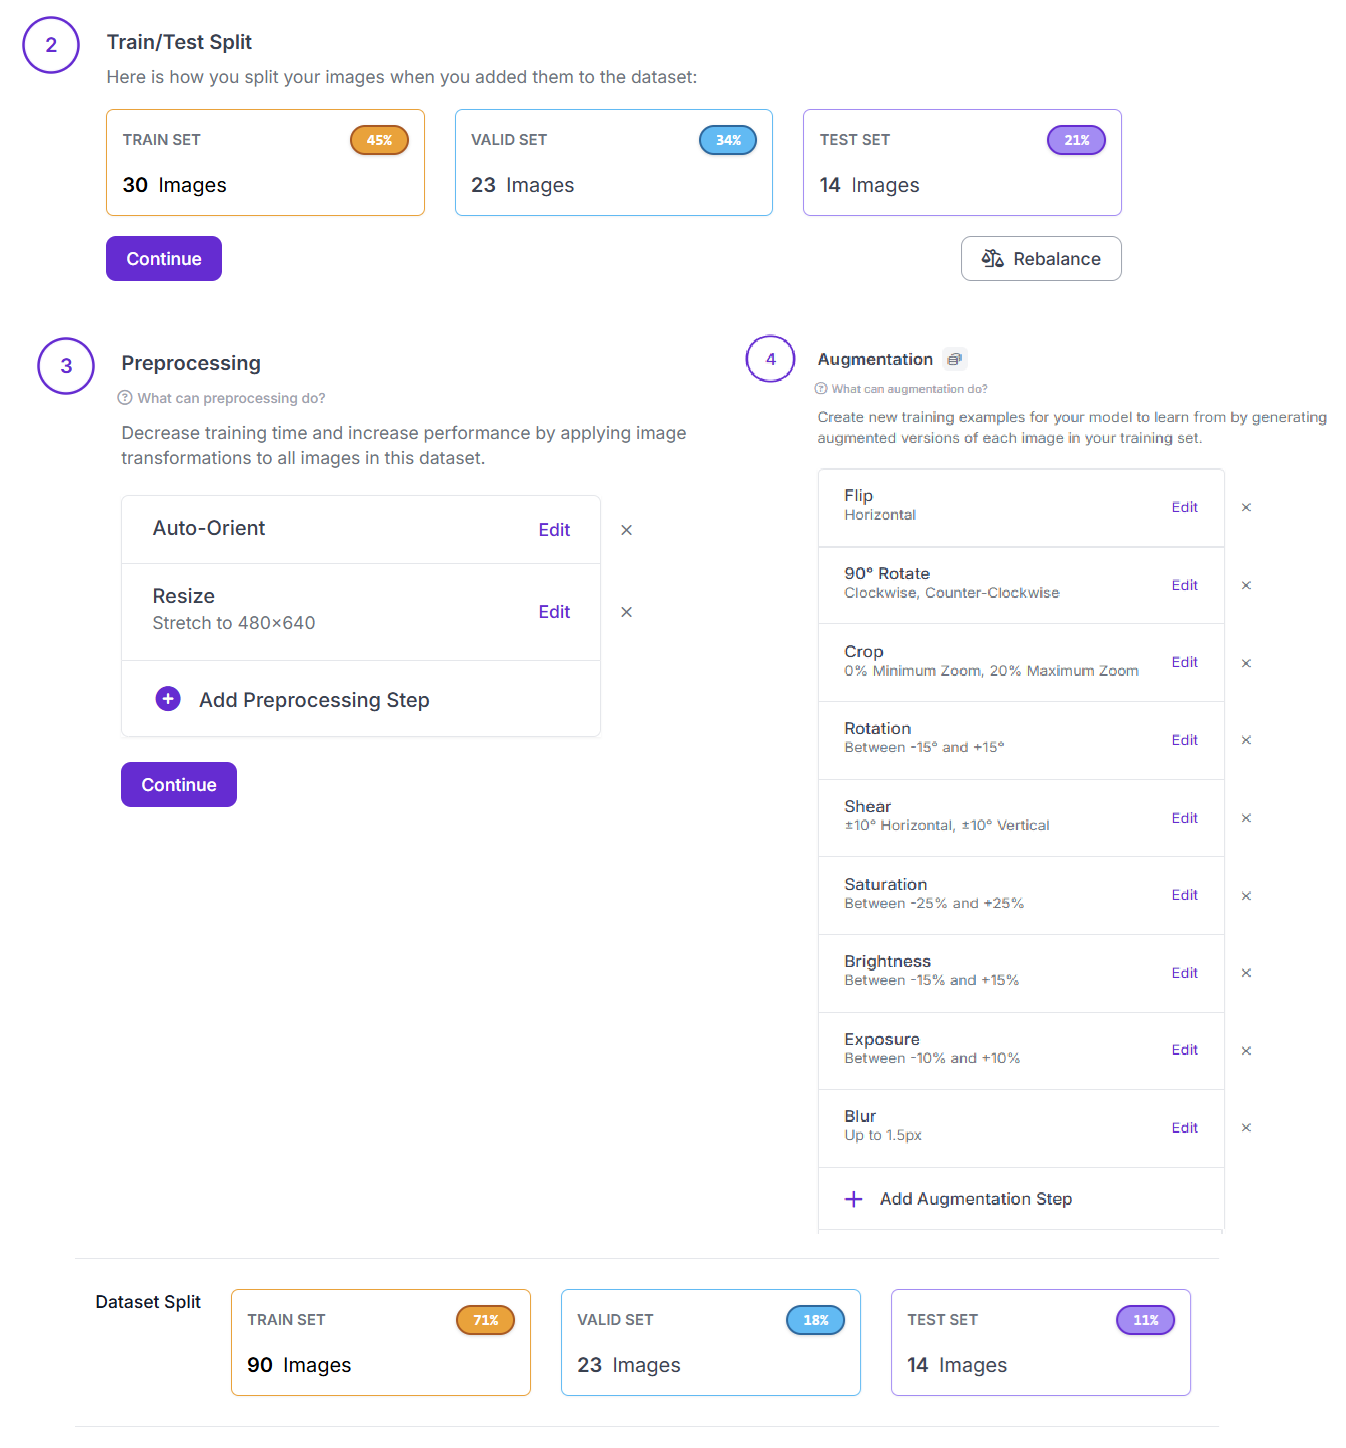

# Скачиваем датасет

Скачиваем созданный датасет с roboflow. Или скачиваем .zip архив (см. README)

In [ ]:
# from roboflow import Roboflow
# rf = Roboflow(api_key="ROBOFLOW_API_KEY_HERE")
# project = rf.workspace("WORKSPASE_NAME_HERE").project("PROJECT_NAME_HERE")
# version = project.version(3)
# dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to dish-detection-3 in yolov11:: 100%|██████████| 266/266 [00:00<00:00, 4768.80it/s]


# Обучение

Напишем функцию для обучения.

**imgsz** выбран именно такой, так как в нашей выборке нет очень мелких блюд, соответственно мы не нуждаемся в очень большом входном разрешении картинки.

**batch** выбран таким, так как в видеопамять Google Colab 15GB помещается максимум **batch=128**. Кроме того, нет смысла в большем батче, так как в обучающей выборке всего 90 картинок:)

**epoch** - стандартное количество эпох для обучения YOLO, для тестирования мы потом берём лучший чекпоинт из всех

В рамках задания я решила подобрать **optimizer** и **learning rate** *(SGD + lr=0.01 или AdamW + lr=0.001)*.

In [3]:
from ultralytics import YOLO
import torch

def training(name, optimizer, lr):
  model = YOLO("yolo11n.pt")

  results = model.train(
    data="dish-detection-3/data.yaml",
    batch=128,
    epochs=300,
    imgsz=(480, 640),
    device=0,
    optimizer=optimizer,
    lr0=lr,
    name=name
  )

  path = model.export(format="onnx")
  return model

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
model_SGD = training(name='SGD_train', optimizer='SGD', lr=0.01)

100%|██████████| 5.35M/5.35M [00:00<00:00, 72.0MB/s]


Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=128, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dish-detection-3/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=300, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=(480, 640), int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=SGD_train, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pre

100%|██████████| 755k/755k [00:00<00:00, 18.3MB/s]

Overriding model.yaml nc=80 with nc=7

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

 10                  -1  1    249728  ultralytics.nn.modules.block.C2PSA           [256, 256, 1]                 
 11                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 12             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 13                  -1  1    111296  ultralytics.nn.modules.block.C3k2            [384, 128, 1, False]          
 14                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 15             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 16                  -1  1     32096  ultralytics.nn.modules.block.C3k2            [256, 64, 1, False]           
 17                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
 18            [-1, 13]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

train: Scanning /content/dish-detection-3/train/labels... 90 images, 3 backgrounds, 0 corrupt: 100%|██████████| 90/90 [00:00<00:00, 3046.71it/s]

train: New cache created: /content/dish-detection-3/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 870.3±426.2 MB/s, size: 54.3 KB)


val: Scanning /content/dish-detection-3/valid/labels... 23 images, 0 backgrounds, 0 corrupt: 100%|██████████| 23/23 [00:00<00:00, 2294.37it/s]

val: New cache created: /content/dish-detection-3/valid/labels.cache


Plotting labels to runs/detect/SGD_train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.001), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/SGD_train
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300      11.1G      1.427      3.796      1.396        686        640: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]

                   all         23         97    0.00427      0.385    0.00927    0.00593

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      2/300      11.1G      1.472      3.766      1.459        647        640: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

                   all         23         97    0.00401      0.385    0.00914     0.0057



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300      11.2G      1.432      3.761      1.432        629        640: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

                   all         23         97    0.00407      0.403    0.00981    0.00632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300      11.2G      1.364      3.786      1.379        640        640: 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

                   all         23         97    0.00424      0.403     0.0101    0.00664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/300      11.2G      1.449      3.775      1.445        668        640: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]

                   all         23         97     0.0044      0.403     0.0107    0.00657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/300      11.1G      1.389        3.8      1.426        605        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]

                   all         23         97    0.00466      0.403     0.0123    0.00818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/300      11.2G      1.395      3.766      1.432        610        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]

                   all         23         97      0.004      0.403     0.0135    0.00943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/300      11.1G      1.408      3.779      1.404        626        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]

                   all         23         97    0.00625      0.474     0.0216     0.0168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/300      11.1G      1.298      3.754      1.359        575        640: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]

                   all         23         97     0.0054       0.52     0.0266     0.0224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/300      11.1G      1.247      3.723      1.301        698        640: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

                   all         23         97     0.0055      0.522     0.0588     0.0533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/300      11.2G      1.201      3.692      1.255        645        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]

                   all         23         97    0.00577      0.511     0.0694     0.0628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/300      11.1G      1.173      3.608      1.229        610        640: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]

                   all         23         97    0.00575      0.457     0.0986     0.0899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/300      11.2G       1.12      3.593      1.197        721        640: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]

                   all         23         97    0.00731      0.493      0.129      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/300      11.2G      1.128      3.524      1.181        629        640: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]

                   all         23         97    0.00678      0.475      0.149       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/300      11.3G      1.036      3.475       1.16        618        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]

                   all         23         97    0.00549       0.41       0.16       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/300      11.2G      1.008      3.401      1.119        604        640: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

                   all         23         97      0.005      0.356      0.162      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/300      11.3G      1.027      3.336      1.117        650        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


                   all         23         97    0.00687      0.417      0.162      0.144

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/300      11.2G     0.9958      3.285      1.094        721        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.01it/s]

                   all         23         97    0.00716      0.432      0.155      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/300      11.2G     0.9446      3.145      1.073        627        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]

                   all         23         97    0.00843       0.45      0.166      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/300      11.1G      0.938      3.046      1.064        697        640: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.53it/s]

                   all         23         97     0.0123      0.458      0.201      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/300      11.1G     0.9559      2.978      1.068        701        640: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]

                   all         23         97     0.0111      0.458      0.246      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/300      11.3G     0.9275       2.84      1.051        684        640: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

                   all         23         97     0.0227      0.518      0.282       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/300      11.2G     0.8918      2.752      1.057        655        640: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]

                   all         23         97     0.0195      0.571      0.297      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/300      11.2G     0.8918       2.61      1.045        665        640: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]

                   all         23         97     0.0238      0.607      0.364       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/300      11.2G     0.8984      2.542      1.052        633        640: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

                   all         23         97     0.0145      0.583       0.36      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/300      11.2G     0.8435      2.315       1.04        647        640: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         23         97     0.0116      0.583      0.378      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/300      11.2G     0.8567      2.165      1.043        600        640: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]

                   all         23         97     0.0265      0.636      0.332      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/300      11.1G     0.8458      2.041      1.048        598        640: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.28it/s]

                   all         23         97     0.0149      0.607      0.354      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/300      11.2G     0.9129      1.976       1.06        674        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]

                   all         23         97     0.0224      0.643      0.377      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/300      11.2G     0.8633      1.792      1.032        641        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]

                   all         23         97     0.0209      0.643       0.46      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/300      11.2G       0.82      1.732      1.023        668        640: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]

                   all         23         97     0.0304      0.696      0.472      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/300      11.1G     0.8289      1.638      1.043        674        640: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]

                   all         23         97     0.0281      0.679      0.471      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/300      11.2G     0.8633      1.699       1.04        742        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all         23         97     0.0271      0.696      0.477      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/300      11.2G     0.8016      1.515      1.037        631        640: 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

                   all         23         97     0.0243      0.679      0.472      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/300        11G     0.8126      1.468      1.031        631        640: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]

                   all         23         97       0.03      0.696      0.478      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/300      11.2G     0.7991      1.489      1.022        719        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]

                   all         23         97     0.0209      0.643      0.464      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/300        11G     0.8263      1.342      1.015        639        640: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]

                   all         23         97     0.0288      0.679      0.475      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/300        11G     0.7806      1.361      1.019        629        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

                   all         23         97          1      0.132      0.456      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/300      11.1G     0.7679      1.306     0.9936        628        640: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

                   all         23         97     0.0235      0.607      0.446      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/300      11.2G      0.786      1.263      1.018        645        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]

                   all         23         97      0.989      0.136      0.417      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/300        11G     0.8678      1.292      1.032        649        640: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

                   all         23         97          1      0.121      0.446      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/300      11.1G     0.7855      1.244      1.025        637        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]

                   all         23         97          1      0.125      0.441      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/300        11G      0.822        1.2      1.005        586        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]

                   all         23         97          1      0.125      0.453        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/300      11.1G     0.7744      1.203      1.014        641        640: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

                   all         23         97          1      0.127      0.462      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/300        11G     0.7257      1.156      1.008        599        640: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

                   all         23         97          1      0.113      0.485      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/300      11.2G     0.7194      1.118      0.993        602        640: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]

                   all         23         97          1      0.123      0.437      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/300      11.2G      0.842       1.14      1.007        622        640: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]

                   all         23         97      0.857      0.133      0.508      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/300      11.2G     0.7628      1.084     0.9818        677        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]

                   all         23         97      0.835      0.136      0.553      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/300      11.2G     0.7441      1.032      0.971        617        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

                   all         23         97       0.74      0.338      0.536      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/300        11G     0.8087      1.007      1.051        595        640: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]

                   all         23         97      0.978      0.136      0.619      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/300      11.2G     0.7859     0.9891     0.9702        694        640: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]

                   all         23         97      0.857      0.128      0.564      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/300        11G      0.678     0.9573     0.9586        670        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

                   all         23         97     0.0906      0.857       0.76      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/300      11.2G     0.7662     0.9452     0.9563        669        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]

                   all         23         97      0.125      0.839      0.786      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/300        11G     0.8212     0.9642      1.037        605        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]

                   all         23         97     0.0942      0.857      0.829      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/300      11.2G     0.6803     0.9106     0.9483        660        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

                   all         23         97      0.186       0.75      0.731      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/300      11.2G      0.728     0.9063     0.9832        633        640: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

                   all         23         97      0.139      0.857      0.838      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/300      11.2G     0.7882     0.8917     0.9931        654        640: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]

                   all         23         97      0.122      0.857      0.825      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/300      11.1G     0.6445     0.8367     0.9379        631        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]

                   all         23         97      0.119      0.857      0.835      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/300      11.1G     0.8222     0.8977     0.9795        731        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]

                   all         23         97       0.08      0.857      0.836      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/300      11.1G     0.7647     0.8892      1.025        559        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]

                   all         23         97      0.994      0.273      0.847      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/300        11G     0.6962     0.8443      0.961        632        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]

                   all         23         97     0.0953      0.804      0.731      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/300      11.2G      0.676      0.808     0.9563        705        640: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

                   all         23         97      0.104      0.857      0.843      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/300      11.2G     0.7726     0.8151     0.9492        638        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]

                   all         23         97     0.0797      0.857      0.844      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/300      11.2G     0.7172     0.8272      0.967        670        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]

                   all         23         97     0.0902      0.857      0.849       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/300        11G     0.6581     0.8157     0.9485        609        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]

                   all         23         97     0.0745      0.708      0.636      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/300      11.2G     0.6869     0.7853     0.9583        621        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]

                   all         23         97          1      0.211      0.848      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/300        11G     0.6787     0.8037     0.9455        554        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]

                   all         23         97          1      0.218      0.847      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/300      11.1G     0.7192     0.7693     0.9844        628        640: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]

                   all         23         97          1      0.199      0.847      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/300      11.1G     0.6781     0.7967     0.9408        656        640: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]

                   all         23         97     0.0791      0.857      0.847      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/300      11.2G     0.6493     0.7538     0.9478        686        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]

                   all         23         97          1      0.237      0.847      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/300      11.1G     0.7025     0.7644     0.9615        627        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

                   all         23         97          1      0.198      0.847      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/300      11.1G     0.6648     0.7466     0.9621        638        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]

                   all         23         97      0.996      0.292      0.847      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/300      11.1G     0.6792     0.7511     0.9428        644        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]

                   all         23         97          1        0.3      0.847      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/300      11.2G     0.6664     0.7357     0.9596        647        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

                   all         23         97      0.997      0.328      0.847       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/300      11.1G     0.7174     0.7559     0.9485        639        640: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]

                   all         23         97          1      0.222      0.841      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/300      11.1G     0.6535     0.7141     0.9296        690        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

                   all         23         97          1      0.311      0.848      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/300      11.2G     0.7351      0.735     0.9452        666        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]

                   all         23         97      0.983      0.468      0.841      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/300        11G     0.7049     0.7228     0.9666        623        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

                   all         23         97          1      0.366      0.848      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/300      11.3G     0.6233     0.7129     0.9339        586        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]

                   all         23         97          1      0.301      0.846      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/300      11.2G     0.7084     0.7251     0.9401        635        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

                   all         23         97      0.998      0.367      0.847      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/300      11.1G     0.7302     0.7219     0.9517        662        640: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

                   all         23         97          1      0.331      0.848       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/300      11.2G     0.6435     0.7025     0.9409        605        640: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]

                   all         23         97          1      0.334      0.849      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/300      11.3G     0.6736     0.6953     0.9199        718        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]

                   all         23         97          1      0.362       0.85       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/300      11.1G     0.5662     0.6446     0.9065        678        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]

                   all         23         97          1      0.464       0.85      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/300      11.2G     0.6269     0.7121     0.9444        585        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


                   all         23         97      0.973       0.63      0.843      0.679

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/300      11.1G     0.6078      0.679     0.9528        652        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]

                   all         23         97      0.995      0.406      0.838      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/300      11.3G     0.6763     0.7119      0.941        607        640: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

                   all         23         97          1      0.521      0.857      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/300      11.1G     0.5571     0.6412     0.8952        652        640: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]

                   all         23         97          1      0.474      0.848      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/300        11G     0.6226      0.692     0.9264        626        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]

                   all         23         97          1      0.277      0.882      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/300      11.2G      0.633     0.7214     0.9244        675        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]

                   all         23         97          1      0.436      0.939      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/300      11.2G      0.622     0.6567     0.9305        637        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]

                   all         23         97          1      0.572      0.932      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/300        11G      0.679     0.6747     0.9426        648        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

                   all         23         97          1      0.318      0.914      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/300      11.2G      0.622     0.6518     0.9337        683        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

                   all         23         97      0.998      0.594      0.933      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/300      11.1G     0.6327     0.6538     0.9472        580        640: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]

                   all         23         97      0.997      0.521      0.944      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/300      11.2G      0.574     0.6424     0.9199        690        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]

                   all         23         97       0.99      0.431      0.924      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/300        11G     0.6216     0.6273     0.9117        614        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]

                   all         23         97      0.989      0.405      0.918      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/300      11.1G      0.571     0.6362     0.9193        611        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]

                   all         23         97      0.987      0.598      0.926      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/300      11.1G     0.5778     0.6378     0.9296        608        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.09it/s]

                   all         23         97       0.98      0.526      0.922      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/300      11.2G     0.6412     0.6313     0.9362        686        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]

                   all         23         97      0.976      0.529      0.933      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/300      11.2G     0.5772     0.6234     0.9103        704        640: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

                   all         23         97      0.975      0.593      0.958      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/300      11.1G     0.6806     0.6697     0.9144        716        640: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]

                   all         23         97      0.948       0.54      0.913      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/300        11G      0.682     0.6623     0.9764        662        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

                   all         23         97      0.949      0.553      0.911      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/300      11.2G     0.6123     0.6306     0.9241        666        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]

                   all         23         97      0.945      0.522      0.913      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/300      11.2G     0.6332     0.6236     0.9354        674        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]

                   all         23         97      0.938      0.664      0.943      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/300      11.1G     0.5585     0.6065     0.9077        615        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]

                   all         23         97      0.962      0.635      0.935      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/300      11.2G     0.6053     0.6253     0.9393        676        640: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]

                   all         23         97      0.981      0.665       0.94      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/300      11.2G     0.6592     0.6724     0.9475        570        640: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.28it/s]

                   all         23         97      0.963      0.453      0.908      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/300      11.1G     0.5617     0.6212      0.907        631        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]

                   all         23         97      0.931       0.55      0.921      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/300      11.1G     0.6546      0.668     0.9214        635        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]

                   all         23         97      0.928      0.499      0.912      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/300      11.1G     0.5717     0.6196     0.9175        623        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]

                   all         23         97      0.834       0.47      0.838       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/300      11.2G     0.6073     0.6258     0.9177        668        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.55it/s]

                   all         23         97      0.889      0.523      0.874      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/300      11.1G       0.55     0.6075     0.9244        623        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

                   all         23         97      0.845      0.566      0.859      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/300      11.1G     0.5973     0.6338     0.9287        589        640: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]

                   all         23         97      0.904      0.511      0.897      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/300      11.2G     0.5243      0.605      0.903        628        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]

                   all         23         97      0.809      0.409      0.814      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/300      11.1G     0.5872     0.6269     0.8965        669        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]

                   all         23         97      0.833      0.462      0.912      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/300      11.1G     0.5566     0.6103     0.9118        613        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]

                   all         23         97      0.911      0.477      0.931      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/300      11.1G     0.5571     0.6006     0.9164        577        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]

                   all         23         97      0.939       0.67      0.955      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/300      11.2G     0.5378     0.6047     0.9153        595        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]

                   all         23         97      0.934       0.79      0.951       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/300      11.3G     0.5699     0.6014     0.9008        666        640: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]

                   all         23         97       0.94      0.875      0.958      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/300        11G     0.5373     0.5862     0.8909        657        640: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]

                   all         23         97      0.932      0.838      0.954      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/300      11.2G     0.5949     0.5967     0.8985        661        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]

                   all         23         97      0.944      0.812      0.964      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/300      11.1G     0.5338      0.577     0.8978        638        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]

                   all         23         97       0.93       0.82      0.948      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/300      11.2G     0.5442     0.5704     0.8987        634        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]

                   all         23         97      0.933       0.81       0.96      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/300      11.1G     0.5347     0.5631     0.8874        683        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]

                   all         23         97      0.937      0.819      0.954      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/300      11.1G     0.5267     0.5669     0.8927        659        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

                   all         23         97      0.936      0.877      0.969      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/300      11.2G     0.5171     0.5702     0.8906        648        640: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

                   all         23         97      0.946      0.881      0.968      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/300      11.1G     0.5504     0.5728     0.8826        675        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

                   all         23         97      0.947      0.889      0.965      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/300      11.1G     0.4914      0.557     0.8775        640        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]

                   all         23         97       0.94      0.898      0.965      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/300      11.1G     0.5238     0.5761     0.8845        721        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]

                   all         23         97      0.942      0.857      0.969      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/300      11.1G     0.4992      0.562     0.8968        650        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.30it/s]

                   all         23         97      0.938      0.835      0.964      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/300      11.2G     0.4923     0.5772     0.8828        636        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]

                   all         23         97      0.944      0.849      0.965      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/300        11G     0.5016     0.5739     0.8921        593        640: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all         23         97      0.937      0.796      0.965      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/300      11.1G     0.4909      0.569      0.884        698        640: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]

                   all         23         97      0.949      0.884      0.969      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/300      11.1G      0.496     0.5597     0.8907        627        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


                   all         23         97      0.949      0.875      0.979      0.854

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/300        11G     0.5346     0.5758     0.9017        622        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]

                   all         23         97      0.944      0.868      0.982      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/300      11.2G      0.536     0.5494     0.8995        625        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]

                   all         23         97      0.938      0.863      0.967       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/300      11.1G     0.4703     0.5417     0.8889        655        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]

                   all         23         97      0.949      0.838      0.961       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/300      11.2G     0.4633     0.5303      0.867        647        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

                   all         23         97      0.933      0.864      0.964      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/300        11G     0.5373     0.5577     0.8912        593        640: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]

                   all         23         97      0.941      0.872      0.963      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/300        11G     0.4624     0.5271     0.8738        685        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]

                   all         23         97       0.93      0.897      0.969      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/300        11G     0.5153     0.5591     0.8818        646        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.44it/s]

                   all         23         97      0.931      0.897      0.967      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/300      11.2G     0.5556     0.5712     0.9152        610        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]

                   all         23         97      0.929      0.899      0.968      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/300        11G     0.5062     0.5278     0.8815        624        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]

                   all         23         97      0.927       0.89      0.964      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/300        11G     0.4884       0.54     0.8937        582        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]

                   all         23         97       0.92      0.896      0.969      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/300        11G     0.4868     0.5775     0.8875        569        640: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]

                   all         23         97      0.922      0.882      0.964      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/300      11.1G     0.4628     0.5428     0.8655        680        640: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]

                   all         23         97      0.918      0.853      0.963        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/300        11G     0.4741     0.5536     0.8612        709        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]

                   all         23         97       0.93      0.874      0.961      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/300        11G      0.497     0.5736     0.8899        614        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]

                   all         23         97       0.93      0.863      0.959      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/300        11G     0.4983     0.5877     0.8922        601        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]

                   all         23         97      0.942      0.871      0.952      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/300      11.1G     0.4487     0.5467     0.8666        651        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]

                   all         23         97      0.935       0.89      0.954      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/300        11G      0.506     0.5599      0.893        611        640: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]

                   all         23         97      0.941      0.896      0.956      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/300        11G     0.5064     0.5601     0.9109        591        640: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]

                   all         23         97      0.934      0.901      0.955      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/300      11.2G     0.4052     0.5186      0.872        570        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]

                   all         23         97      0.942      0.923       0.96      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/300      11.1G     0.5089     0.5681     0.8948        662        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]

                   all         23         97      0.949       0.92      0.961       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/300      11.1G     0.4624     0.5177     0.8692        683        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

                   all         23         97       0.96      0.913      0.958       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/300      11.1G     0.4205     0.4939     0.8678        651        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]

                   all         23         97      0.947      0.903      0.962      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/300      11.1G        0.5     0.5238     0.8776        579        640: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]

                   all         23         97      0.934      0.921      0.966      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/300      11.2G     0.4328     0.4879     0.8679        669        640: 100%|██████████| 1/1 [00:01<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]

                   all         23         97      0.942      0.926      0.965      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/300      11.2G     0.4388     0.5026     0.8717        636        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]

                   all         23         97      0.976      0.921      0.968      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/300      11.1G     0.4822     0.4983     0.8726        611        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]

                   all         23         97      0.973      0.924      0.967      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/300      11.2G     0.4343      0.485      0.855        650        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]

                   all         23         97      0.973      0.909      0.967      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/300      11.2G     0.4943     0.5037     0.8755        658        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]

                   all         23         97      0.972      0.913      0.965      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/300      11.1G     0.4634     0.4964     0.8852        638        640: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]

                   all         23         97       0.97      0.901      0.953      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/300      11.1G     0.4115     0.4754       0.86        630        640: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]

                   all         23         97      0.951      0.917      0.963      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/300      11.1G     0.4508     0.4936     0.8764        594        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

                   all         23         97       0.95      0.926      0.969      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/300      11.2G     0.4726      0.505     0.8688        656        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]

                   all         23         97      0.964      0.916      0.973      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/300      11.1G     0.4248     0.4912     0.8488        705        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]

                   all         23         97      0.933      0.941      0.972      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/300      11.2G      0.446     0.5083     0.8639        680        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]

                   all         23         97      0.937      0.956      0.975      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/300      11.1G     0.4242     0.5065     0.8599        552        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]

                   all         23         97      0.972      0.928      0.974      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/300      11.2G     0.4397     0.5073     0.8641        610        640: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]

                   all         23         97      0.969      0.921      0.972      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/300      11.1G     0.4423     0.5079     0.8775        642        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]

                   all         23         97      0.979      0.925      0.974      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/300      11.2G     0.4548     0.5116     0.8652        705        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]

                   all         23         97      0.973      0.928      0.975      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/300      11.2G     0.4531     0.4937     0.8785        577        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

                   all         23         97       0.95      0.935      0.972      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/300      11.2G     0.4494      0.479     0.8607        620        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]

                   all         23         97      0.945      0.933       0.97      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/300        11G     0.4236     0.4757     0.8746        655        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]

                   all         23         97      0.932      0.939      0.971      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/300      11.2G     0.4711     0.4812     0.8606        738        640: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]

                   all         23         97      0.935       0.94      0.967      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/300      11.2G     0.3813     0.4606     0.8485        750        640: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]

                   all         23         97      0.915      0.937      0.969      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/300      11.1G     0.4343     0.4842      0.864        628        640: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]

                   all         23         97      0.886      0.934       0.97      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/300      11.1G     0.4022     0.4673     0.8657        587        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

                   all         23         97      0.938        0.9      0.968      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/300      11.1G     0.4376     0.4863     0.8738        659        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]

                   all         23         97      0.921      0.937      0.977      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/300      11.2G     0.4401     0.4992     0.8802        651        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.28it/s]

                   all         23         97      0.938      0.926      0.979      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/300      11.2G     0.3893     0.4653     0.8511        636        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]

                   all         23         97      0.947      0.916      0.975      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/300      11.2G     0.4817     0.5173     0.8682        739        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.09it/s]

                   all         23         97      0.975       0.91      0.975      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/300      11.1G     0.4073     0.4751     0.8533        600        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]

                   all         23         97      0.935      0.932      0.976        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/300      11.1G      0.388     0.4624     0.8664        622        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]

                   all         23         97      0.932      0.944      0.977      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/300      11.1G     0.4141     0.4817     0.8562        567        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]

                   all         23         97      0.934      0.943      0.975      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/300      11.2G      0.469     0.4882     0.8904        650        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]

                   all         23         97      0.934      0.943      0.971      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/300      11.2G     0.4511     0.4768     0.8682        715        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]

                   all         23         97      0.925      0.951      0.976      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/300      11.1G     0.3814     0.4394     0.8512        625        640: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.55it/s]

                   all         23         97      0.924      0.943      0.975      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/300      11.1G     0.4128     0.4463     0.8579        684        640: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.09it/s]

                   all         23         97      0.923      0.946      0.979      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/300      11.2G     0.3877     0.4419     0.8602        613        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]

                   all         23         97      0.916      0.951      0.979      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/300      11.1G     0.3776     0.4532     0.8496        723        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]

                   all         23         97       0.92      0.951      0.979      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/300        11G     0.4298     0.4633     0.8743        586        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]

                   all         23         97      0.915      0.951      0.979      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/300      11.2G      0.416     0.4491     0.8599        705        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]

                   all         23         97      0.918      0.947      0.979       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/300      11.2G     0.3891     0.4256     0.8549        681        640: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

                   all         23         97       0.92      0.941       0.98      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/300      11.1G     0.3727     0.4313     0.8584        619        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]

                   all         23         97      0.924      0.948      0.981      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/300      11.1G     0.5125     0.4863     0.8763        661        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]

                   all         23         97      0.912      0.958      0.979      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/300      11.1G     0.3743     0.4494      0.859        641        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]

                   all         23         97      0.923      0.949      0.978      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/300        11G     0.3917     0.4567     0.8571        597        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.88it/s]

                   all         23         97      0.918      0.956      0.979      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/300      11.2G     0.3727     0.4556     0.8472        702        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]

                   all         23         97      0.895      0.951      0.976       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/300        11G     0.4221     0.4666     0.8521        667        640: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]

                   all         23         97      0.915       0.95      0.972       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/300      11.1G     0.3561     0.4371     0.8431        621        640: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]

                   all         23         97      0.907      0.931      0.971      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/300      11.2G     0.3898     0.4621     0.8609        667        640: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]

                   all         23         97      0.908      0.916      0.971      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/300      11.3G     0.3801     0.4494     0.8564        657        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

                   all         23         97      0.908      0.889      0.963      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/300        11G     0.3923     0.4624     0.8527        628        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]

                   all         23         97      0.912      0.884      0.967      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/300      11.2G     0.3894     0.4504     0.8543        687        640: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]

                   all         23         97      0.918      0.921      0.968      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/300      11.2G     0.3897     0.4525     0.8507        667        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]

                   all         23         97      0.918      0.936       0.97      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/300      11.1G     0.4349     0.4512     0.8745        614        640: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

                   all         23         97      0.919      0.935      0.972      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/300      11.1G     0.4241     0.4385     0.8743        670        640: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]

                   all         23         97      0.919      0.934      0.972      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/300      11.3G     0.3656     0.4308     0.8711        635        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

                   all         23         97      0.925      0.935       0.97      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/300        11G     0.3478     0.4296     0.8638        539        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]

                   all         23         97      0.925      0.936       0.97      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/300      11.1G     0.4612     0.4667     0.8525        688        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]

                   all         23         97      0.919      0.928      0.968      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/300      11.3G     0.4118     0.4433     0.8494        653        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]

                   all         23         97      0.917      0.928       0.97      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/300      11.1G     0.3505     0.4221     0.8552        623        640: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]

                   all         23         97      0.919      0.926       0.97      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/300        11G     0.3876     0.4316     0.8384        668        640: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]

                   all         23         97       0.91       0.92      0.969      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/300        11G     0.3437     0.4157     0.8474        584        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]

                   all         23         97      0.909       0.92      0.969      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/300      11.1G     0.3684     0.4368     0.8481        655        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]

                   all         23         97      0.917       0.92      0.967      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/300      11.2G     0.3585     0.4308     0.8436        644        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]

                   all         23         97      0.915      0.918      0.966       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/300      11.2G     0.3666     0.4194     0.8426        678        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]

                   all         23         97      0.923      0.913      0.967      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/300      11.2G     0.3664     0.4197     0.8387        671        640: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

                   all         23         97      0.927      0.918      0.962      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/300        11G     0.3486     0.4166     0.8459        587        640: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]

                   all         23         97      0.923       0.92      0.964      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/300      11.1G     0.3803      0.429      0.849        607        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

                   all         23         97      0.926       0.92      0.966      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/300      11.2G     0.3308     0.4088      0.845        655        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]

                   all         23         97      0.925      0.931      0.968      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/300      11.2G     0.4025     0.4371     0.8466        649        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

                   all         23         97      0.961      0.909      0.971      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/300      11.3G     0.3879     0.4286     0.8736        610        640: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]

                   all         23         97      0.929      0.944      0.977      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/300        11G     0.3717     0.4098     0.8484        648        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

                   all         23         97      0.929      0.954      0.978      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/300      11.1G     0.3457     0.4117     0.8459        684        640: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]

                   all         23         97      0.927      0.957      0.978       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/300        11G     0.3464     0.4112     0.8427        603        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]

                   all         23         97      0.968      0.924      0.979      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/300      11.2G     0.3332     0.4147     0.8342        714        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

                   all         23         97      0.927      0.959      0.979      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/300      11.1G     0.3515     0.4188     0.8366        692        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]

                   all         23         97      0.972      0.922      0.979      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/300      11.2G      0.374     0.4088      0.859        677        640: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

                   all         23         97      0.967      0.923      0.979      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/300      11.2G     0.3542     0.4086     0.8291        695        640: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

                   all         23         97      0.937      0.937      0.978        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/300        11G     0.3797     0.4163     0.8575        611        640: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]

                   all         23         97      0.947      0.939      0.976      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/300      11.1G     0.3416      0.413     0.8442        670        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]

                   all         23         97      0.935      0.944      0.976        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/300      11.3G     0.3405     0.4039     0.8445        679        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]

                   all         23         97      0.925      0.949      0.973      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/300      11.1G     0.3312      0.397     0.8482        611        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]

                   all         23         97      0.935      0.943      0.973      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/300      11.1G     0.3333     0.4037     0.8439        710        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]

                   all         23         97      0.937      0.945      0.973      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/300      11.1G     0.3328       0.41     0.8341        653        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

                   all         23         97      0.939      0.943      0.973      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/300      11.2G     0.3417     0.4077     0.8388        650        640: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

                   all         23         97      0.942      0.942      0.972      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/300        11G     0.3312      0.389      0.854        649        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]

                   all         23         97      0.942       0.94      0.972      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/300        11G      0.318     0.3952     0.8387        670        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]

                   all         23         97      0.944       0.94      0.973       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/300      11.1G     0.3262     0.4102     0.8421        551        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]

                   all         23         97      0.944       0.94      0.973      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/300        11G     0.3627      0.409     0.8235        652        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]

                   all         23         97      0.961      0.929      0.974      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/300      11.1G     0.3376     0.4034     0.8375        595        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]

                   all         23         97      0.964      0.929      0.977      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    245/300      11.1G     0.3009     0.3893     0.8339        617        640: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

                   all         23         97      0.947      0.941      0.978      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/300        11G     0.3164     0.3998     0.8428        633        640: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

                   all         23         97      0.956      0.936      0.975      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    247/300      11.1G     0.3896      0.427     0.8455        671        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]

                   all         23         97      0.948      0.941      0.975      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    248/300      11.2G     0.3546     0.4105     0.8532        665        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]

                   all         23         97      0.966      0.929      0.974      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/300      11.2G      0.346     0.3983     0.8423        701        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]

                   all         23         97      0.944      0.945      0.974      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    250/300      11.2G     0.3206     0.3839     0.8405        619        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]

                   all         23         97      0.968      0.925      0.971      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    251/300      11.3G     0.3074     0.3884     0.8366        657        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

                   all         23         97      0.968      0.925      0.972      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    252/300      11.1G     0.3221     0.3895     0.8391        603        640: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]

                   all         23         97      0.972      0.925      0.971      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    253/300      11.1G     0.3108     0.3845     0.8433        662        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]

                   all         23         97      0.967      0.922      0.973      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    254/300      11.2G     0.3251     0.3888     0.8288        654        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]

                   all         23         97      0.969       0.92      0.974      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    255/300      11.2G     0.3164     0.3967     0.8538        590        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]

                   all         23         97      0.957      0.922      0.972      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    256/300        11G     0.3352     0.3828     0.8563        632        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]

                   all         23         97      0.923      0.948      0.974      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    257/300      11.1G     0.3486     0.4146     0.8508        582        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

                   all         23         97      0.921      0.944      0.971      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    258/300      11.2G     0.3625     0.3926     0.8373        690        640: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]

                   all         23         97      0.931      0.939       0.97      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    259/300      11.1G     0.2985     0.3799     0.8313        598        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]

                   all         23         97      0.931      0.939       0.97      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    260/300      11.1G     0.3204     0.3935     0.8376        670        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]

                   all         23         97      0.931      0.938       0.97      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    261/300        11G     0.3137     0.3952     0.8378        643        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]

                   all         23         97       0.91      0.949       0.97      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    262/300      11.2G     0.3307     0.3889     0.8484        640        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]

                   all         23         97      0.914      0.951       0.97      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    263/300        11G      0.308     0.3734     0.8363        644        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]

                   all         23         97      0.914      0.954       0.97      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    264/300      11.2G     0.3039     0.3784     0.8374        657        640: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

                   all         23         97      0.914      0.958       0.97      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    265/300      11.1G     0.3122     0.3858     0.8366        663        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

                   all         23         97      0.915      0.952      0.971      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    266/300      11.1G     0.3105     0.3847     0.8433        648        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]

                   all         23         97      0.916      0.952      0.971      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    267/300      11.1G      0.305      0.368     0.8226        690        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]

                   all         23         97      0.918      0.953      0.972      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    268/300      11.2G      0.305     0.3749     0.8344        680        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]

                   all         23         97      0.916      0.954      0.971      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    269/300      11.2G     0.3589      0.386      0.843        734        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]

                   all         23         97      0.918      0.954      0.973      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    270/300      11.2G     0.2979     0.3681     0.8377        640        640: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

                   all         23         97      0.916      0.955      0.973      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    271/300      11.1G     0.2959     0.3752       0.85        603        640: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]

                   all         23         97      0.917      0.951      0.971      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    272/300      11.1G      0.285     0.3674     0.8344        595        640: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

                   all         23         97      0.913      0.945      0.971      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    273/300        11G      0.317     0.3811     0.8314        624        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


                   all         23         97      0.916      0.947      0.971      0.909

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    274/300      11.2G     0.2751     0.3535     0.8283        584        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]

                   all         23         97      0.917       0.95      0.971      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    275/300        11G     0.2991      0.374     0.8398        625        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]

                   all         23         97      0.918       0.95      0.973      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    276/300      11.1G     0.2824     0.3636     0.8314        647        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]

                   all         23         97      0.919      0.951      0.974      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    277/300      11.1G     0.2749     0.3726     0.8267        700        640: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]

                   all         23         97      0.919      0.954      0.975      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    278/300        11G      0.285     0.3655     0.8345        599        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]

                   all         23         97      0.924      0.962      0.975      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    279/300      11.1G     0.2877     0.3625     0.8442        596        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]

                   all         23         97      0.921      0.962      0.975      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    280/300        11G     0.2896     0.3617     0.8388        622        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]

                   all         23         97      0.927      0.962      0.975      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    281/300      11.1G     0.3157     0.3744     0.8255        649        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

                   all         23         97      0.928      0.963      0.977      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    282/300      11.2G     0.3229     0.3752     0.8212        618        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         23         97      0.933      0.968      0.978      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    283/300      11.1G     0.2819     0.3646     0.8372        613        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all         23         97      0.933      0.968      0.978      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    284/300        11G     0.3002     0.3696     0.8304        657        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]

                   all         23         97      0.933      0.968      0.978      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    285/300      11.2G     0.2973     0.3623     0.8363        653        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]

                   all         23         97      0.927      0.965      0.977      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    286/300      11.1G     0.2808     0.3482     0.8251        635        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

                   all         23         97      0.927      0.965      0.976      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    287/300        11G     0.3086     0.3647     0.8258        710        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]

                   all         23         97      0.971      0.929      0.976      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    288/300        11G     0.2856     0.3645      0.835        628        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]

                   all         23         97      0.972      0.929      0.976      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    289/300      11.1G     0.2697     0.3478     0.8372        627        640: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

                   all         23         97      0.973      0.929      0.976       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    290/300      11.1G      0.266     0.3557     0.8168        679        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]

                   all         23         97      0.927      0.972      0.977       0.92


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    291/300        11G     0.2541     0.4595     0.7927        340        640: 100%|██████████| 1/1 [00:03<00:00,  3.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

                   all         23         97      0.927      0.972      0.976      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    292/300        11G     0.2801     0.4773     0.8081        340        640: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

                   all         23         97      0.918      0.967      0.974      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    293/300        11G     0.2378     0.4335     0.7818        340        640: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]

                   all         23         97      0.921       0.97      0.974      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    294/300      10.9G      0.224     0.4118     0.7845        339        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all         23         97      0.921      0.971      0.974      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    295/300        11G     0.2357     0.4315     0.7981        339        640: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]

                   all         23         97      0.921       0.97      0.972      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    296/300        11G     0.2296     0.4084     0.7992        340        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]

                   all         23         97      0.922      0.969      0.972       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    297/300        11G     0.2254     0.4064     0.7946        340        640: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]

                   all         23         97      0.922      0.969      0.972      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    298/300        11G     0.2201     0.4185     0.7882        340        640: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]

                   all         23         97      0.974      0.929      0.972      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    299/300        11G     0.2277     0.4107     0.7823        339        640: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]

                   all         23         97      0.928       0.97      0.972      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    300/300        11G     0.2177     0.4104     0.8008        339        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]

                   all         23         97      0.928       0.97      0.972      0.913



300 epochs completed in 0.178 hours.
Optimizer stripped from runs/detect/SGD_train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/SGD_train/weights/best.pt, 5.5MB

Validating runs/detect/SGD_train/weights/best.pt...
Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,583,517 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.50it/s]


                   all         23         97      0.967      0.923      0.979      0.924
                borsch          8          8      0.967          1      0.995        0.9
          caesar salad          8          8      0.951          1      0.995      0.995
               chicken         22         22      0.961      0.818      0.944      0.925
           greek salad          8          8      0.949          1      0.995      0.995
                  meat         20         20      0.959          1      0.995      0.942
          pumpkin soup          8          8          1      0.641      0.935      0.728
                   tea         23         23      0.981          1      0.995      0.982
Speed: 0.2ms preprocess, 1.6ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/SGD_train
Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more 

In [5]:
model_AdamW = training(name='AdamW_train', optimizer='AdamW', lr=0.001)

Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=128, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dish-detection-3/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=300, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=(480, 640), int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=AdamW_train, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0

train: Scanning /content/dish-detection-3/train/labels.cache... 90 images, 3 backgrounds, 0 corrupt: 100%|██████████| 90/90 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 648.4±397.2 MB/s, size: 54.3 KB)


val: Scanning /content/dish-detection-3/valid/labels.cache... 23 images, 0 backgrounds, 0 corrupt: 100%|██████████| 23/23 [00:00<?, ?it/s]


Plotting labels to runs/detect/AdamW_train/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.001), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/AdamW_train
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300      11.2G      1.427      3.796      1.396        686        640: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

                   all         23         97    0.00427      0.385    0.00927    0.00593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/300      11.2G      1.472      3.766      1.459        647        640: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]

                   all         23         97    0.00401      0.385    0.00914     0.0057



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300      11.2G      1.432      3.761      1.432        629        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all         23         97    0.00407      0.403    0.00981    0.00632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300      11.2G      1.364      3.786      1.379        640        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]

                   all         23         97    0.00424      0.403     0.0101    0.00664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/300      11.2G      1.449      3.775      1.445        668        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

                   all         23         97     0.0044      0.403     0.0107    0.00657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/300      11.1G      1.389        3.8      1.426        605        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]

                   all         23         97    0.00466      0.403     0.0123    0.00818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/300      11.2G      1.395      3.766      1.432        610        640: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]

                   all         23         97    0.00382      0.333      0.095     0.0766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/300      11.2G      1.182      3.564      1.219        626        640: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

                   all         23         97    0.00396      0.397      0.122      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/300      11.2G      1.162      3.302      1.151        575        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]

                   all         23         97     0.0129      0.354     0.0908     0.0493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/300      11.2G      1.061      3.108      1.087        698        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]

                   all         23         97    0.00183      0.286     0.0368     0.0205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/300      11.2G       1.07       2.98       1.08        645        640: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]

                   all         23         97    0.00191      0.286     0.0891     0.0619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/300      11.2G     0.9684      2.778      1.042        610        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]

                   all         23         97    0.00191      0.286      0.142      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/300      11.3G     0.9965      2.659      1.043        721        640: 100%|██████████| 1/1 [00:01<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

                   all         23         97    0.00189      0.279       0.15      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/300      11.3G     0.9697      2.527      1.049        629        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

                   all         23         97    0.00189      0.286      0.159      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/300      11.3G     0.8998      2.424      1.046        618        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]

                   all         23         97    0.00188      0.286      0.135     0.0947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/300      11.2G     0.8925      2.247      1.028        604        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]

                   all         23         97    0.00172      0.266     0.0982     0.0698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/300      11.3G     0.8948      2.165      1.024        650        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]

                   all         23         97    0.00215      0.265     0.0151     0.0088



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/300      11.2G     0.9363      2.081       1.03        721        640: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

                   all         23         97    0.00065       0.11    0.00138   0.000421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/300      11.2G     0.8586      1.901      1.011        627        640: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

                   all         23         97   0.000486     0.0779   0.000775   0.000181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/300      11.2G     0.8729      1.817      1.006        697        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]

                   all         23         97   0.000337     0.0519   0.000368   8.18e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/300      11.2G     0.8768      1.754       1.02        701        640: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]

                   all         23         97   0.000301     0.0455   0.000293   5.35e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/300      11.3G     0.8354      1.703     0.9959        684        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]

                   all         23         97   0.000212     0.0325    0.00018   2.06e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/300      11.2G     0.8302      1.638      1.001        655        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/300      11.2G      0.809       1.57     0.9856        665        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]

                   all         23         97   8.26e-05      0.013   5.64e-05   8.09e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/300      11.2G     0.8026      1.494     0.9836        633        640: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]

                   all         23         97   8.06e-05      0.013   5.59e-05   1.36e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/300      11.2G      0.777      1.441     0.9842        647        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]

                   all         23         97   0.000237      0.039   0.000239   3.94e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/300      11.3G     0.7939      1.349     0.9955        600        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]

                   all         23         97   0.000231      0.039   0.000228   3.64e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/300      11.2G     0.8062       1.33     0.9776        598        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]

                   all         23         97   0.000268     0.0455   0.000297   6.46e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/300      11.2G     0.8116      1.273     0.9829        674        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]

                   all         23         97   0.000334     0.0584   0.000452   0.000124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/300      11.2G     0.7771      1.217     0.9635        641        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]

                   all         23         97   0.000529     0.0974    0.00106    0.00025



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/300      11.2G     0.8291      1.202     0.9931        668        640: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]

                   all         23         97   0.000546      0.104    0.00151   0.000344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/300      11.2G     0.8325      1.176      1.013        674        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]

                   all         23         97   0.000448     0.0844   0.000979   0.000324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/300      11.2G     0.7841       1.15     0.9796        742        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]

                   all         23         97   0.000482     0.0844    0.00083   0.000306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/300      11.3G     0.8368      1.095     0.9961        631        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]

                   all         23         97    0.00082      0.148    0.00179   0.000407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/300        11G     0.7761      1.052     0.9867        631        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

                   all         23         97   0.000825      0.136    0.00212    0.00059



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/300      11.2G     0.7681      1.036     0.9768        719        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

                   all         23         97   0.000997      0.208    0.00228   0.000788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/300        11G     0.7091     0.9316      0.952        639        640: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]

                   all         23         97   0.000977      0.208    0.00246   0.000853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/300        11G     0.7673     0.9415       0.98        629        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]

                   all         23         97    0.00112      0.261    0.00266   0.000725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/300      11.2G     0.7064     0.9119     0.9494        628        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

                   all         23         97    0.00109      0.266    0.00264   0.000571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/300      11.3G     0.7105     0.9014     0.9676        645        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]

                   all         23         97     0.0011      0.255      0.003   0.000621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/300        11G     0.7822     0.8821     0.9776        649        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]

                   all         23         97    0.00119      0.279    0.00405   0.000847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/300      11.2G     0.7335     0.8498     0.9654        637        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

                   all         23         97     0.0107      0.308     0.0291    0.00577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/300        11G     0.6952     0.8021      0.959        586        640: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

                   all         23         97    0.00439      0.281      0.034    0.00818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/300      11.2G     0.6795     0.8031     0.9465        641        640: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]

                   all         23         97    0.00168      0.119      0.012    0.00234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/300        11G     0.6562     0.7601     0.9689        599        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.35it/s]


                   all         23         97    0.00136     0.0951     0.0076    0.00113

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/300      11.2G     0.6996     0.7512     0.9564        602        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

                   all         23         97    0.00232      0.109     0.0119    0.00206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/300      11.3G     0.7217     0.7454     0.9502        622        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]

                   all         23         97    0.00405       0.18     0.0438     0.0115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/300      11.2G     0.7046      0.745      0.938        677        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

                   all         23         97     0.0142      0.319     0.0969     0.0326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/300      11.2G     0.6959     0.6878     0.9509        617        640: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]

                   all         23         97     0.0395      0.419      0.141     0.0576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/300        11G       0.73     0.6909     0.9836        595        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]

                   all         23         97     0.0533      0.406      0.165     0.0653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/300      11.2G     0.6295     0.6873     0.9169        694        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]

                   all         23         97     0.0547      0.384      0.177     0.0589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/300        11G      0.657     0.6513     0.9196        670        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]

                   all         23         97     0.0769      0.457      0.216     0.0833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/300      11.2G     0.6189     0.6361     0.9067        669        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

                   all         23         97      0.099       0.47      0.253      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/300        11G     0.6547     0.6185     0.9497        605        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

                   all         23         97      0.131      0.509      0.286      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/300      11.2G     0.6144     0.6143     0.9191        660        640: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]

                   all         23         97      0.176      0.503      0.359      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/300      11.2G     0.6167     0.5954     0.9194        633        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]

                   all         23         97      0.186      0.484      0.347      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/300      11.3G     0.6174     0.5948     0.9219        654        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]

                   all         23         97      0.268      0.431      0.368      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/300      11.2G     0.6256     0.5964     0.9142        631        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]

                   all         23         97      0.264       0.42      0.375      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/300      11.2G     0.6115       0.58     0.9102        731        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

                   all         23         97      0.243      0.438      0.415      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/300      11.2G     0.7256     0.6165      0.984        559        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

                   all         23         97      0.234      0.451      0.437      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/300        11G     0.6395     0.5781     0.9459        632        640: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

                   all         23         97      0.222      0.475       0.48       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/300      11.2G     0.5762      0.564      0.908        705        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]

                   all         23         97      0.219      0.521      0.505       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/300      11.3G      0.651     0.5458     0.8977        638        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]

                   all         23         97      0.219      0.529      0.511      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/300      11.3G     0.6289     0.5765     0.9174        670        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]

                   all         23         97      0.364      0.553      0.598      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/300        11G      0.545     0.5433     0.9012        609        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


                   all         23         97      0.356      0.606      0.626      0.473

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/300      11.2G     0.5826     0.5329     0.9068        621        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]

                   all         23         97      0.354      0.601      0.628      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/300        11G     0.5537     0.5207     0.8907        554        640: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

                   all         23         97      0.353      0.594      0.628      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/300      11.2G     0.5681     0.5197     0.9122        628        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.36it/s]

                   all         23         97      0.363      0.594      0.623      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/300      11.2G      0.529     0.5166     0.8915        656        640: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]

                   all         23         97      0.358      0.619      0.632      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/300      11.3G     0.5885     0.5398     0.9049        686        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

                   all         23         97      0.369      0.636      0.644      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/300      11.2G     0.6031     0.5091      0.913        627        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]

                   all         23         97      0.375      0.601      0.619      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/300      11.2G     0.5903     0.5236     0.9215        638        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]

                   all         23         97       0.38      0.601      0.613      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/300      11.2G     0.5439     0.5319      0.893        644        640: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

                   all         23         97      0.371      0.654       0.63      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/300      11.2G     0.5566     0.5125     0.9024        647        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]

                   all         23         97      0.378      0.672      0.641      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/300      11.2G     0.5891     0.5123     0.9113        639        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]

                   all         23         97      0.526      0.815      0.787      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/300      11.2G      0.578     0.5141      0.891        690        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]

                   all         23         97      0.459      0.851      0.821      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/300      11.2G     0.5538     0.4923     0.8882        666        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

                   all         23         97      0.449      0.857      0.829      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/300        11G     0.6183     0.4956     0.9299        623        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]

                   all         23         97      0.446      0.857      0.825      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/300      11.3G     0.5887     0.4983     0.9358        586        640: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

                   all         23         97      0.433      0.857      0.817      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/300      11.2G     0.5881      0.482     0.9015        635        640: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]

                   all         23         97      0.437      0.851      0.818      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/300      11.2G      0.594     0.4934     0.9062        662        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]

                   all         23         97      0.439      0.836      0.808      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/300      11.2G     0.5584     0.5003     0.8908        605        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]

                   all         23         97      0.447      0.836      0.791      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/300      11.3G     0.5137     0.4934     0.8708        718        640: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]

                   all         23         97      0.458      0.844      0.785      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/300      11.2G     0.5211     0.4647     0.8849        678        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.09it/s]

                   all         23         97      0.454      0.844      0.779       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/300      11.3G     0.5615     0.4836      0.923        585        640: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]

                   all         23         97      0.457      0.851      0.777      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/300      11.2G     0.5123     0.4793     0.9002        652        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]

                   all         23         97      0.442      0.826      0.761      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/300      11.4G     0.5608      0.483     0.8951        607        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.38it/s]

                   all         23         97      0.446      0.844      0.787       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/300      11.2G     0.7015     0.5091      0.928        652        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]

                   all         23         97      0.428      0.851      0.796      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/300        11G     0.5316     0.4784     0.8992        626        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]

                   all         23         97      0.434      0.851      0.826      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/300      11.2G     0.5356       0.49     0.8859        675        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

                   all         23         97      0.419      0.851      0.828      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/300      11.2G     0.5982     0.4713     0.9102        637        640: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]

                   all         23         97      0.415      0.851       0.83       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/300        11G     0.5606     0.4624     0.8958        648        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]

                   all         23         97      0.399      0.857      0.832      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/300      11.2G     0.5416     0.4681     0.8943        683        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

                   all         23         97      0.368      0.857       0.83      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/300      11.2G     0.5175     0.4496     0.8984        580        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]

                   all         23         97      0.741      0.682      0.825      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/300      11.3G     0.5668     0.4817     0.8879        690        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]

                   all         23         97       0.76      0.604       0.82      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/300        11G     0.5398     0.4395      0.881        614        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

                   all         23         97      0.779       0.68      0.805      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/300      11.2G     0.5349     0.4718     0.8887        611        640: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]

                   all         23         97      0.786      0.681        0.8      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/300      11.2G     0.5954      0.477     0.9214        608        640: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]

                   all         23         97       0.79      0.681      0.804      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/300      11.3G     0.5242     0.4416     0.8914        686        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]

                   all         23         97      0.793      0.668      0.816       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/300      11.2G     0.4985      0.445     0.8806        704        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]

                   all         23         97      0.792      0.665      0.818      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/300      11.2G       0.54     0.4447     0.8754        716        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]

                   all         23         97      0.761      0.718      0.808      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/300        11G     0.5176     0.4461     0.9041        662        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.44it/s]

                   all         23         97      0.408      0.857      0.789      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/300      11.3G     0.4878     0.4448     0.8825        666        640: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

                   all         23         97       0.39      0.857      0.793      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/300      11.2G     0.4939     0.4304     0.8883        674        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]

                   all         23         97      0.724      0.706      0.794      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/300      11.2G     0.4864     0.4286     0.8891        615        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]

                   all         23         97      0.885      0.718      0.884      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/300      11.2G     0.5043     0.4298      0.883        676        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]

                   all         23         97      0.912      0.681      0.884       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/300      11.2G     0.5143     0.4394     0.8975        570        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]

                   all         23         97      0.811      0.788      0.912      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/300      11.2G     0.4819     0.4166     0.8813        631        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]

                   all         23         97      0.682      0.857      0.905      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/300      11.2G     0.5095     0.4359     0.8809        635        640: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]

                   all         23         97      0.649      0.857      0.902      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/300      11.2G     0.5343     0.4458     0.8966        623        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]

                   all         23         97      0.478      0.893      0.902      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/300      11.2G     0.4564     0.4208     0.8686        668        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]

                   all         23         97      0.899      0.665        0.9      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/300      11.2G     0.4591     0.4272     0.8872        623        640: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

                   all         23         97      0.924      0.639      0.914      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/300      11.2G     0.5099     0.4193     0.8933        589        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]

                   all         23         97       0.89      0.776      0.935      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/300      11.2G     0.5357      0.436     0.8925        628        640: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

                   all         23         97      0.833      0.849      0.927      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/300      11.2G     0.5048     0.4343     0.8758        669        640: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

                   all         23         97      0.879      0.845      0.929      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/300      11.2G     0.5048      0.433     0.8867        613        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]

                   all         23         97      0.929       0.83      0.934      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/300      11.2G     0.4709     0.4106     0.8866        577        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

                   all         23         97      0.909      0.828      0.936      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/300      11.2G     0.4447     0.4127     0.8708        595        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]

                   all         23         97      0.901      0.824      0.937      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/300      11.3G     0.4769     0.4181     0.8656        666        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

                   all         23         97      0.913      0.819      0.944      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/300        11G     0.4759     0.4086     0.8569        657        640: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

                   all         23         97      0.925      0.822      0.952      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/300      11.2G     0.4685     0.4058     0.8592        661        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

                   all         23         97      0.949       0.82       0.95      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/300      11.2G     0.4623     0.4002     0.8668        638        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]

                   all         23         97      0.959       0.82       0.95       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/300      11.3G     0.4751     0.3928     0.8782        634        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]

                   all         23         97      0.963      0.821      0.954       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/300      11.2G      0.469     0.3975     0.8647        683        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

                   all         23         97      0.963      0.823      0.955      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/300      11.2G     0.4593     0.3976     0.8779        659        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]

                   all         23         97      0.969      0.823      0.954      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/300      11.2G     0.4396     0.3864     0.8646        648        640: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

                   all         23         97      0.932       0.83      0.953      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/300      11.2G     0.4621     0.3996     0.8654        675        640: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]

                   all         23         97      0.935      0.831      0.952      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/300      11.2G     0.4316     0.3682     0.8586        640        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]

                   all         23         97      0.942      0.831      0.952      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/300      11.2G     0.4217     0.3886     0.8556        721        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]

                   all         23         97      0.951      0.867      0.953      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/300      11.2G     0.4468     0.3828     0.8751        650        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]

                   all         23         97      0.946      0.873      0.962      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/300      11.2G      0.425     0.3947     0.8595        636        640: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]

                   all         23         97      0.948      0.874      0.962      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/300        11G     0.4396     0.3821     0.8733        593        640: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

                   all         23         97      0.946      0.877      0.963      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/300      11.2G     0.4227     0.3804     0.8571        698        640: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]

                   all         23         97      0.942      0.878      0.965      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/300      11.2G     0.4274     0.3705     0.8581        627        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]

                   all         23         97      0.941       0.88      0.965       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/300        11G     0.4642     0.3939     0.8701        622        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]

                   all         23         97      0.923      0.883      0.962      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/300      11.3G     0.4702     0.3885     0.8666        625        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]

                   all         23         97      0.925      0.883      0.962      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/300      11.2G     0.4297     0.3834     0.8695        655        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]

                   all         23         97      0.929      0.882      0.962      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/300      11.2G      0.415     0.3797     0.8407        647        640: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]

                   all         23         97      0.914      0.882      0.962      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/300        11G     0.4149     0.3699     0.8587        593        640: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]

                   all         23         97        0.9      0.888      0.949      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/300        11G     0.4265     0.3766      0.861        685        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]

                   all         23         97      0.889      0.904      0.934       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/300        11G     0.4332      0.379     0.8679        646        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]

                   all         23         97      0.877      0.906       0.92      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/300      11.3G     0.4847     0.3868     0.8868        610        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]

                   all         23         97      0.873      0.906      0.923      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/300        11G     0.4183     0.3598     0.8496        624        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]

                   all         23         97      0.878      0.897      0.955      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/300        11G     0.4359     0.3724      0.869        582        640: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]

                   all         23         97      0.877      0.894       0.96      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/300        11G     0.4553     0.3939     0.8787        569        640: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]

                   all         23         97      0.848      0.902      0.956      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/300      11.2G     0.4551     0.3643      0.859        680        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]

                   all         23         97      0.837      0.886      0.939      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/300        11G       0.44     0.3818     0.8497        709        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]

                   all         23         97       0.84      0.865      0.939      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/300        11G      0.462     0.3792     0.8801        614        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

                   all         23         97      0.845      0.849      0.948      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/300        11G     0.5154      0.386     0.8908        601        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]

                   all         23         97      0.835      0.854      0.955      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/300      11.2G     0.4538     0.3876     0.8537        651        640: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all         23         97      0.846      0.868      0.957      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/300        11G     0.4455     0.3697     0.8723        611        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]

                   all         23         97      0.918      0.859      0.965      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/300        11G     0.4632     0.3812     0.8768        591        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]

                   all         23         97      0.935      0.863      0.966      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/300      11.3G     0.5488     0.3909     0.8847        570        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]

                   all         23         97      0.941      0.878      0.975      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/300      11.2G     0.5737     0.4369     0.9048        662        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]

                   all         23         97      0.944      0.895      0.975      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/300      11.2G     0.4833     0.3932     0.8598        683        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

                   all         23         97      0.944      0.905      0.974      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/300      11.2G     0.4205     0.3759     0.8589        651        640: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

                   all         23         97      0.948      0.916      0.974      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/300      11.2G     0.5008     0.3722      0.869        579        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]

                   all         23         97      0.943      0.919      0.973      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/300      11.2G     0.5024     0.3821     0.8751        669        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]

                   all         23         97      0.944      0.919      0.973      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/300      11.3G      0.486     0.3895     0.8729        636        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]

                   all         23         97      0.947      0.913      0.972      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/300      11.2G     0.4426     0.3665     0.8527        611        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]

                   all         23         97      0.961      0.914      0.971      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/300      11.3G     0.4336     0.3665     0.8381        650        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


                   all         23         97      0.961       0.92       0.97      0.909

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/300      11.3G     0.4922     0.3817     0.8687        658        640: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

                   all         23         97      0.944      0.935       0.97      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/300      11.2G     0.4463     0.3729     0.8708        638        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]

                   all         23         97      0.937      0.954      0.969      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/300      11.2G     0.4179     0.3513     0.8552        630        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]

                   all         23         97      0.938      0.958      0.969      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/300      11.2G     0.4119      0.344     0.8606        594        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]

                   all         23         97      0.942      0.958      0.969      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/300      11.2G     0.3932     0.3331     0.8464        656        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]

                   all         23         97      0.938      0.958       0.97      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/300      11.2G     0.4123     0.3577     0.8423        705        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]

                   all         23         97      0.937      0.957       0.97      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/300      11.2G     0.4203     0.3562     0.8561        680        640: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

                   all         23         97      0.957      0.941       0.97      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/300      11.2G     0.3738     0.3411     0.8424        552        640: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

                   all         23         97       0.96      0.941       0.97      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/300      11.3G     0.4115     0.3494     0.8491        610        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]

                   all         23         97      0.939      0.953       0.97      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/300      11.2G     0.4262     0.3573     0.8697        642        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]

                   all         23         97      0.933      0.961       0.97      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/300      11.2G     0.4337     0.3601     0.8585        705        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]

                   all         23         97      0.918      0.963      0.969      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/300      11.2G     0.3861     0.3329     0.8493        577        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]

                   all         23         97      0.955      0.925      0.967      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/300      11.2G     0.3664     0.3253     0.8399        620        640: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

                   all         23         97      0.947      0.921      0.967      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/300        11G     0.3944     0.3359     0.8561        655        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]

                   all         23         97      0.927      0.962      0.972      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/300      11.2G     0.3819     0.3532     0.8389        738        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]

                   all         23         97      0.928      0.958      0.972       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/300      11.3G     0.3829     0.3535      0.834        750        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]

                   all         23         97      0.926      0.948      0.971      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/300      11.2G     0.3907     0.3414     0.8498        628        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]

                   all         23         97      0.922      0.944      0.971      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/300      11.2G     0.3933     0.3353     0.8603        587        640: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]

                   all         23         97       0.93      0.935      0.971      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/300      11.2G      0.403     0.3391     0.8572        659        640: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]

                   all         23         97      0.931      0.932       0.97      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/300      11.3G      0.409     0.3571     0.8717        651        640: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]

                   all         23         97      0.931      0.931      0.971      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/300      11.3G     0.3728     0.3379     0.8406        636        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]

                   all         23         97      0.931       0.93      0.972      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/300      11.2G     0.4045     0.3718     0.8501        739        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]

                   all         23         97      0.929      0.931      0.969      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/300      11.2G     0.3694     0.3297     0.8401        600        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]

                   all         23         97      0.929      0.933      0.968      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/300      11.2G     0.3917     0.3328     0.8569        622        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]

                   all         23         97       0.93      0.933       0.97      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/300      11.2G     0.3807     0.3301     0.8473        567        640: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]

                   all         23         97      0.931      0.934       0.97      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/300      11.2G      0.399     0.3405     0.8671        650        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]

                   all         23         97      0.932      0.934       0.97      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/300      11.2G      0.399     0.3553     0.8473        715        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]

                   all         23         97      0.932      0.937      0.969      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/300      11.2G     0.3871     0.3338     0.8428        625        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.44it/s]

                   all         23         97      0.931       0.94      0.969      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/300      11.2G     0.4114     0.3433     0.8472        684        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]

                   all         23         97      0.929      0.944      0.969      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/300      11.2G     0.3693     0.3294     0.8498        613        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]

                   all         23         97      0.928      0.953      0.969      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/300      11.2G     0.3637     0.3396     0.8375        723        640: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]

                   all         23         97      0.928      0.954      0.969      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/300        11G      0.398     0.3258     0.8547        586        640: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]

                   all         23         97       0.97      0.922      0.969      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/300      11.2G     0.3657     0.3279     0.8418        705        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]

                   all         23         97      0.973      0.922      0.969      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/300      11.3G     0.3649     0.3204     0.8453        681        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

                   all         23         97      0.977      0.922      0.969      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/300      11.2G     0.3685     0.3196     0.8516        619        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]

                   all         23         97       0.98      0.922      0.969      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/300      11.2G      0.396     0.3232     0.8472        661        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]

                   all         23         97      0.981      0.922      0.969      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/300      11.2G     0.3995     0.3418     0.8596        641        640: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

                   all         23         97      0.981      0.922      0.969      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/300        11G     0.3883     0.3217     0.8507        597        640: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

                   all         23         97       0.98      0.923      0.969      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/300      11.2G     0.3762     0.3184     0.8406        702        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]

                   all         23         97      0.979      0.922      0.969      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/300        11G     0.3814     0.3184     0.8417        667        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]

                   all         23         97      0.977      0.922       0.97      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/300      11.2G     0.3798     0.3215     0.8436        621        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]

                   all         23         97      0.923      0.964       0.97      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/300      11.2G     0.3704     0.3235     0.8503        667        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]

                   all         23         97      0.923      0.969       0.97      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/300      11.3G     0.3569     0.3102     0.8525        657        640: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

                   all         23         97      0.922      0.969      0.969      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/300        11G     0.3708     0.3238     0.8456        628        640: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

                   all         23         97      0.923      0.969       0.97      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/300      11.2G     0.3478     0.3133     0.8394        687        640: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]

                   all         23         97      0.924      0.969       0.97      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/300      11.2G     0.3707     0.3313     0.8404        667        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]

                   all         23         97      0.927      0.969      0.972      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/300      11.2G     0.3637     0.3195     0.8543        614        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]

                   all         23         97      0.928      0.968      0.973      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/300      11.2G     0.3462     0.3058     0.8454        670        640: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]

                   all         23         97      0.928      0.967      0.973      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/300      11.3G     0.3556     0.3149     0.8544        635        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]

                   all         23         97      0.926      0.968      0.972       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/300        11G     0.3489     0.3147     0.8558        539        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.48it/s]

                   all         23         97      0.925      0.969      0.972      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/300      11.2G     0.4052     0.3261     0.8334        688        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]

                   all         23         97      0.925      0.969      0.971      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/300      11.3G     0.3541     0.3116     0.8318        653        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]

                   all         23         97      0.928      0.969      0.971      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/300      11.2G     0.3379     0.3051     0.8492        623        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]

                   all         23         97      0.928      0.958      0.971      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/300        11G     0.3475     0.3054     0.8278        668        640: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]

                   all         23         97      0.928       0.95      0.972      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/300        11G     0.3154     0.2873     0.8363        584        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]

                   all         23         97      0.927      0.949      0.972      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/300      11.2G     0.3278     0.3057     0.8371        655        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]

                   all         23         97      0.931      0.944      0.972      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/300      11.2G      0.338     0.3091     0.8356        644        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]

                   all         23         97      0.931      0.943      0.972      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/300      11.3G      0.363     0.3054     0.8396        678        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]

                   all         23         97      0.931      0.943      0.972      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/300      11.2G     0.3393     0.2988     0.8279        671        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

                   all         23         97      0.931      0.944       0.97      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/300        11G     0.3334     0.2919     0.8319        587        640: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]

                   all         23         97      0.931      0.944       0.97      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/300      11.2G     0.3356     0.3007     0.8368        607        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]

                   all         23         97      0.932      0.944       0.97      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/300      11.2G     0.3367     0.3001     0.8414        655        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]

                   all         23         97      0.932      0.945      0.972       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/300      11.3G     0.3415     0.3071     0.8383        649        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]

                   all         23         97       0.93      0.951      0.973      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/300      11.3G     0.3413     0.3065     0.8499        610        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]

                   all         23         97       0.93      0.955      0.973      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/300        11G     0.3311     0.2898     0.8355        648        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.55it/s]

                   all         23         97       0.93       0.96      0.973      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/300      11.2G     0.3442     0.3038     0.8399        684        640: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]

                   all         23         97      0.929      0.966      0.973      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/300        11G     0.3298     0.2969     0.8361        603        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]

                   all         23         97      0.928      0.967      0.973      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/300      11.3G     0.3138     0.3019     0.8259        714        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]

                   all         23         97      0.928      0.968      0.973      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/300      11.2G     0.3113     0.2904     0.8292        692        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]

                   all         23         97      0.929      0.968      0.975      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/300      11.3G     0.3222     0.2913     0.8446        677        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]

                   all         23         97       0.93      0.968      0.975      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/300      11.3G     0.3242     0.2919     0.8246        695        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]

                   all         23         97       0.93      0.969      0.975      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/300        11G      0.351     0.2966      0.844        611        640: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

                   all         23         97      0.927      0.969      0.972      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/300      11.2G     0.3307     0.2973     0.8388        670        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

                   all         23         97      0.927      0.969      0.972      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/300      11.3G     0.3214     0.2977     0.8327        679        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]

                   all         23         97      0.926      0.969      0.971      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/300      11.2G     0.3139     0.2751     0.8418        611        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.85it/s]

                   all         23         97      0.927      0.969      0.971      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/300      11.2G     0.3157     0.2962      0.837        710        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]

                   all         23         97      0.927      0.967      0.971      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/300      11.2G     0.3119     0.2824     0.8283        653        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

                   all         23         97      0.925      0.965      0.971      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/300      11.3G     0.3093     0.2888     0.8277        650        640: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]

                   all         23         97      0.925      0.962      0.971      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/300        11G     0.3266     0.2895     0.8448        649        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]

                   all         23         97      0.927      0.955      0.972      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/300        11G     0.3065     0.2867     0.8342        670        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

                   all         23         97      0.939      0.944      0.972       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/300      11.2G     0.3092     0.2853      0.837        551        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]

                   all         23         97      0.939      0.943      0.973      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/300        11G     0.3344     0.2939     0.8179        652        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]

                   all         23         97      0.941      0.944      0.973      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/300      11.2G     0.3226     0.2841      0.832        595        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all         23         97      0.942      0.943      0.974      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    245/300      11.2G     0.3018     0.2795     0.8274        617        640: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]

                   all         23         97      0.937      0.943      0.974      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/300        11G     0.3232     0.2927     0.8429        633        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]

                   all         23         97      0.937      0.943      0.974      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    247/300      11.2G     0.3366     0.3008     0.8333        671        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]

                   all         23         97      0.927      0.951      0.975      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    248/300      11.2G      0.325     0.3057     0.8375        665        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]

                   all         23         97       0.93       0.96      0.976      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/300      11.2G     0.3397     0.2953     0.8354        701        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]

                   all         23         97      0.932      0.956      0.976      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    250/300      11.2G     0.3323      0.285     0.8336        619        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]

                   all         23         97      0.933      0.953      0.975      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    251/300      11.3G     0.3242     0.2813     0.8343        657        640: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]

                   all         23         97      0.934      0.952      0.975      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    252/300      11.2G     0.3181     0.2778      0.838        603        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

                   all         23         97      0.934      0.951      0.975      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    253/300      11.2G     0.3149     0.2813     0.8375        662        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

                   all         23         97      0.934      0.951      0.978      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    254/300      11.3G     0.3244     0.2868     0.8255        654        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]

                   all         23         97       0.96      0.926      0.977      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    255/300      11.2G      0.337     0.2856     0.8561        590        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]

                   all         23         97      0.961      0.925      0.974      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    256/300        11G     0.3084     0.2738     0.8462        632        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

                   all         23         97      0.961      0.924      0.974      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    257/300      11.2G     0.3328     0.2954     0.8445        582        640: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]

                   all         23         97      0.961      0.924      0.974      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    258/300      11.3G     0.3553     0.2953     0.8314        690        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]

                   all         23         97       0.96      0.923      0.974      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    259/300      11.2G     0.3312     0.2905     0.8302        598        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]

                   all         23         97      0.958      0.923      0.974      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    260/300      11.2G     0.3218     0.2866     0.8309        670        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]

                   all         23         97      0.958      0.923      0.978      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    261/300        11G     0.3211     0.2825     0.8339        643        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]

                   all         23         97      0.957      0.923      0.979      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    262/300      11.2G     0.3255     0.2759     0.8426        640        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

                   all         23         97      0.956      0.924      0.978      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    263/300        11G     0.3041     0.2769     0.8321        644        640: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

                   all         23         97      0.954      0.924      0.979      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    264/300      11.3G      0.312     0.2817     0.8279        657        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]

                   all         23         97      0.951      0.925      0.978      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    265/300      11.2G     0.3015     0.2769     0.8345        663        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]

                   all         23         97       0.95      0.925      0.977      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    266/300      11.2G     0.2971     0.2806     0.8331        648        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]

                   all         23         97      0.944      0.929      0.978      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    267/300      11.2G     0.2913     0.2749     0.8205        690        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]

                   all         23         97      0.943      0.931      0.978      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    268/300      11.2G     0.3104     0.2864     0.8321        680        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

                   all         23         97      0.942      0.933      0.974      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    269/300      11.3G     0.3706     0.2983     0.8423        734        640: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]

                   all         23         97       0.94      0.936      0.974      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    270/300      11.2G     0.2748     0.2579     0.8314        640        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]

                   all         23         97      0.939      0.939      0.974      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    271/300      11.2G     0.2911     0.2655     0.8432        603        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]

                   all         23         97      0.939      0.941      0.974      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    272/300      11.2G     0.2946     0.2626     0.8331        595        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]

                   all         23         97      0.931      0.949      0.974      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    273/300        11G     0.2997     0.2724     0.8255        624        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

                   all         23         97       0.93      0.952      0.973      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    274/300      11.2G     0.2743     0.2545     0.8234        584        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]

                   all         23         97      0.933      0.953      0.973      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    275/300        11G     0.2956     0.2697     0.8365        625        640: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

                   all         23         97      0.934      0.953      0.973      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    276/300      11.2G     0.2747     0.2681     0.8268        647        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]

                   all         23         97      0.934      0.954      0.973      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    277/300      11.2G     0.2865     0.2769      0.827        700        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]

                   all         23         97      0.934      0.956      0.974      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    278/300        11G     0.2817     0.2565     0.8307        599        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]

                   all         23         97      0.934      0.958      0.974      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    279/300      11.2G     0.3005     0.2647     0.8458        596        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]

                   all         23         97      0.935      0.958      0.974      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    280/300        11G      0.276     0.2605     0.8373        622        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]

                   all         23         97      0.935      0.958      0.974      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    281/300      11.2G     0.3149     0.2782     0.8242        649        640: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.73it/s]

                   all         23         97      0.936      0.958      0.974      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    282/300      11.3G     0.2826     0.2627     0.8137        618        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]

                   all         23         97      0.936      0.959      0.974       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    283/300      11.2G     0.2806     0.2556     0.8312        613        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]

                   all         23         97      0.936       0.96      0.974      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    284/300        11G     0.2899     0.2637     0.8281        657        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]

                   all         23         97      0.936       0.96      0.974      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    285/300      11.2G     0.2845     0.2636     0.8289        653        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]

                   all         23         97      0.936      0.961      0.974      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    286/300      11.2G     0.2808     0.2554     0.8256        635        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

                   all         23         97      0.937      0.961      0.974      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    287/300        11G     0.2975     0.2669     0.8193        710        640: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]

                   all         23         97      0.936      0.962      0.974      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    288/300        11G     0.2831     0.2589     0.8333        628        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]

                   all         23         97      0.936      0.962      0.974      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    289/300      11.2G     0.2603     0.2489     0.8314        627        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.23it/s]

                   all         23         97      0.936      0.963      0.974      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    290/300      11.2G     0.2765     0.2646     0.8195        679        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]

                   all         23         97      0.936      0.963      0.974      0.918


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    291/300        11G     0.2533     0.3245     0.7885        340        640: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

                   all         23         97      0.937      0.964      0.974      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    292/300        11G     0.3068     0.3608     0.8109        340        640: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

                   all         23         97      0.936      0.965      0.974      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    293/300        11G     0.2514     0.3202     0.7763        340        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

                   all         23         97      0.936      0.965      0.974      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    294/300        11G     0.2342     0.3057     0.7798        339        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

                   all         23         97      0.936      0.965      0.974      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    295/300        11G     0.2551     0.3087     0.7999        339        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]

                   all         23         97      0.936      0.964      0.974      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    296/300        11G      0.233     0.2813     0.7903        340        640: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]

                   all         23         97      0.935      0.963      0.974      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    297/300        11G     0.2189     0.2765     0.7851        340        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]

                   all         23         97      0.935      0.963      0.974      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    298/300        11G     0.2239     0.2741     0.7881        340        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]

                   all         23         97      0.934      0.962      0.974       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    299/300        11G     0.2278     0.2754     0.7756        339        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.42it/s]

                   all         23         97      0.934      0.962      0.974      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    300/300        11G     0.2185     0.2646     0.7947        339        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]

                   all         23         97      0.934      0.962      0.974      0.919



300 epochs completed in 0.185 hours.
Optimizer stripped from runs/detect/AdamW_train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/AdamW_train/weights/best.pt, 5.5MB

Validating runs/detect/AdamW_train/weights/best.pt...
Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,583,517 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


                   all         23         97      0.934      0.956      0.974      0.928
                borsch          8          8      0.892          1      0.995      0.922
          caesar salad          8          8      0.923          1      0.995      0.995
               chicken         22         22      0.907      0.887      0.945       0.92
           greek salad          8          8      0.925          1      0.995      0.995
                  meat         20         20      0.922          1      0.995      0.958
          pumpkin soup          8          8          1      0.806      0.895      0.719
                   tea         23         23      0.971          1      0.995      0.988
Speed: 0.3ms preprocess, 1.5ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/AdamW_train
Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
YOLO11n summary (fused): 100 layers, 2,583,517 parameters, 0 gradients, 6.3 GFLOPs

P

# Тестирование


Протестируем обученные модели

In [6]:
model_path_SGD = 'runs/detect/SGD_train/weights/best.pt'
model_SGD = YOLO(model_path_SGD)

In [7]:
metrics_val = model_SGD.val(name='SGD_val')

Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,583,517 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1259.5±530.9 MB/s, size: 57.6 KB)


val: Scanning /content/dish-detection-3/valid/labels.cache... 23 images, 0 backgrounds, 0 corrupt: 100%|██████████| 23/23 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]


                   all         23         97      0.967      0.923      0.979      0.922
                borsch          8          8      0.966          1      0.995        0.9
          caesar salad          8          8      0.951          1      0.995      0.995
               chicken         22         22      0.961      0.818      0.944      0.925
           greek salad          8          8      0.949          1      0.995      0.995
                  meat         20         20      0.958          1      0.995      0.942
          pumpkin soup          8          8          1      0.641      0.935      0.716
                   tea         23         23      0.981          1      0.995      0.977
Speed: 0.2ms preprocess, 17.0ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/SGD_val


In [8]:
metrics_test = model_SGD.val(name='SGD_test', split='test')

Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1466.0±459.1 MB/s, size: 53.2 KB)


val: Scanning /content/dish-detection-3/test/labels... 14 images, 0 backgrounds, 0 corrupt: 100%|██████████| 14/14 [00:00<00:00, 2593.88it/s]

val: New cache created: /content/dish-detection-3/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


                   all         14         73      0.987      0.922      0.976      0.946
                borsch          8          8      0.987          1      0.995       0.94
          caesar salad          8          8      0.976          1      0.995      0.995
               chicken         14         14          1       0.99      0.995      0.978
           greek salad          8          8      0.973          1      0.995      0.995
                  meat         14         14      0.989          1      0.995      0.982
          pumpkin soup          7          7          1      0.465      0.864      0.746
                   tea         14         14      0.982          1      0.995      0.985
Speed: 0.2ms preprocess, 11.2ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/detect/SGD_test


In [ ]:
result = model_SGD(source='3_1.MOV', conf=0.25, save=True, name='predict_SGD')


WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/2978) /content/3_1.MOV: 640x384 1 borsch, 1 caesar salad, 1 chicken, 1 greek salad, 1 meat, 1 pumpkin soup, 1 tea, 52.1ms
video 1/1 (frame 2/2978) /content/3_1.MOV: 640x384 1 borsch, 1 caesar salad, 1 chicken, 1 greek salad, 1 meat, 1 pumpkin soup, 1 tea, 16.3ms
video 1/1 (frame 3/2978) /content/3_1.MOV: 640x384 1 borsch, 1 caesar salad, 1 chicken, 1 greek salad, 1 meat, 1 pumpkin soup, 1 tea, 12.4ms
video 1/1 (frame 4/2978) /content

In [2]:
from ultralytics import YOLO
model_path_AdamW = 'runs/detect/AdamW_train/weights/best.pt'
model_AdamW = YOLO(model_path_AdamW)

In [3]:
metrics_val = model_AdamW.val(name='AdamW_val')

Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,583,517 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 160.9±190.8 MB/s, size: 56.7 KB)


val: Scanning /content/dish-detection-3/valid/labels.cache... 23 images, 0 backgrounds, 0 corrupt: 100%|██████████| 23/23 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


                   all         23         97      0.934      0.956      0.974      0.928
                borsch          8          8      0.892          1      0.995      0.922
          caesar salad          8          8      0.922          1      0.995      0.995
               chicken         22         22      0.907      0.887      0.945       0.92
           greek salad          8          8      0.924          1      0.995      0.995
                  meat         20         20      0.922          1      0.995      0.958
          pumpkin soup          8          8          1      0.807      0.895      0.719
                   tea         23         23      0.971          1      0.995      0.988
Speed: 0.3ms preprocess, 16.4ms inference, 0.0ms loss, 18.7ms postprocess per image
Results saved to runs/detect/AdamW_val


In [4]:
metrics_test = model_AdamW.val(name='AdamW_test', split='test')

Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 357.8±202.6 MB/s, size: 57.9 KB)


val: Scanning /content/dish-detection-3/test/labels.cache... 14 images, 0 backgrounds, 0 corrupt: 100%|██████████| 14/14 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


                   all         14         73      0.983      0.924      0.955      0.929
                borsch          8          8      0.994          1      0.995      0.943
          caesar salad          8          8      0.985          1      0.995      0.995
               chicken         14         14      0.929          1      0.995      0.991
           greek salad          8          8      0.991          1      0.995      0.981
                  meat         14         14      0.992          1      0.995       0.97
          pumpkin soup          7          7          1      0.465      0.713      0.644
                   tea         14         14      0.991          1      0.995      0.976
Speed: 0.2ms preprocess, 10.1ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/AdamW_test


In [ ]:
result = model_AdamW(source='3_1.MOV', conf=0.25, save=True, name='predict_AdamW')


WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/2978) /content/3_1.MOV: 640x384 1 borsch, 1 caesar salad, 1 chicken, 1 greek salad, 1 meat, 1 pumpkin soup, 1 tea, 67.4ms
video 1/1 (frame 2/2978) /content/3_1.MOV: 640x384 1 borsch, 1 caesar salad, 1 chicken, 1 greek salad, 1 meat, 1 pumpkin soup, 1 tea, 17.2ms
video 1/1 (frame 3/2978) /content/3_1.MOV: 640x384 1 borsch, 1 caesar salad, 1 chicken, 1 greek salad, 1 meat, 1 pumpkin soup, 1 tea, 14.3ms
video 1/1 (frame 4/2978) /content

# Сравнение результатов

Сравним обученные модели

In [1]:
import pandas as pd
import seaborn as sns

results_df_AdamW = pd.read_csv('runs/detect/AdamW_train/results.csv')
results_df_AdamW.head(5)

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,2.63997,1.42690,3.79582,1.39583,0.00427,0.38506,0.00927,0.00593,1.02368,3.61817,1.24845,0.100000,0.000000,0.000000
1,2,5.69357,1.47174,3.76613,1.45924,0.00401,0.38506,0.00914,0.00570,1.01803,3.61646,1.24315,0.099010,0.000010,0.000010
2,3,8.29098,1.43170,3.76061,1.43244,0.00407,0.40292,0.00981,0.00632,1.00678,3.61075,1.23408,0.098020,0.000020,0.000020
3,4,10.17580,1.36351,3.78645,1.37920,0.00424,0.40292,0.01011,0.00664,0.98984,3.60514,1.22175,0.097030,0.000030,0.000030
4,5,12.01490,1.44882,3.77537,1.44461,0.00440,0.40292,0.01075,0.00657,0.97804,3.60328,1.21347,0.096039,0.000039,0.000039


In [2]:
results_df_SGD = pd.read_csv('runs/detect/SGD_train/results.csv')
results_df_SGD.head(5)

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,3.91483,1.42690,3.79582,1.39583,0.00427,0.38506,0.00927,0.00593,1.02368,3.61817,1.24845,0.100000,0.000000,0.000000
1,2,6.09470,1.47174,3.76613,1.45924,0.00401,0.38506,0.00914,0.00570,1.01803,3.61646,1.24315,0.099100,0.000100,0.000100
2,3,8.86112,1.43170,3.76061,1.43244,0.00407,0.40292,0.00981,0.00632,1.00678,3.61075,1.23408,0.098199,0.000199,0.000199
3,4,11.16250,1.36351,3.78645,1.37920,0.00424,0.40292,0.01011,0.00664,0.98984,3.60514,1.22175,0.097297,0.000297,0.000297
4,5,12.95740,1.44882,3.77537,1.44461,0.00440,0.40292,0.01075,0.00657,0.97804,3.60328,1.21347,0.096395,0.000395,0.000395


In [3]:
import matplotlib.pyplot as plt

results_df_AdamW = results_df_AdamW.assign(model='model-AdamW')
results_df_SGD = results_df_SGD.assign(model='model-SGD')

In [8]:
both = pd.concat([results_df_AdamW, results_df_SGD], ignore_index=True)
both['metrics/F1'] = (2 * both['metrics/precision(B)'] * both['metrics/recall(B)'] /
                 (both['metrics/precision(B)'] + both['metrics/recall(B)']).clip(lower=1e-12))

In [10]:
both_long = both.melt(id_vars=['epoch', 'model'],
                      value_vars=['train/box_loss', 'train/cls_loss',
                                  'val/box_loss', 'val/cls_loss',
                                  'metrics/precision(B)', 'metrics/recall(B)', 'metrics/F1',
                                  'metrics/mAP50(B)', 'metrics/mAP50-95(B)'],
                      var_name='metric',
                      value_name='value')

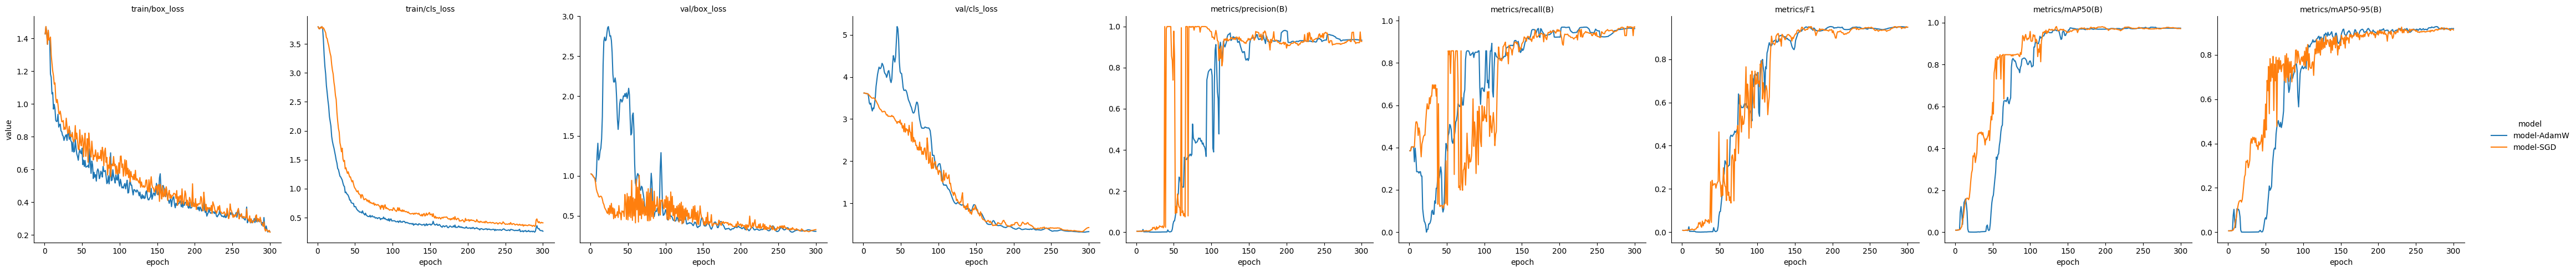

In [11]:
g = sns.relplot(data=both_long,
                x='epoch', y='value',
                hue='model',
                col='metric',
                kind='line',
                facet_kws={'sharey': False})
g.set_titles(col_template='{col_name}')
plt.show()

# Выводы

Как видно из графиков выше и результатов, модель обученная с помощью оптимизатора **AdamW** показала себя немного лучше. У неё быстрее сходимость и метрики качества чуть выше.

Однако более репрезентативные результаты можно получить увеличив выборку (снять блюда с разных ракурсов, в разной степени "съеденности", в разной обстановке). Таким образом мы бы получили более универсальную модель.

Сложности, с которыми столкнулась: изначально был выбран не очень удачный инструмент для аннотирования *labelImg*. Попробовав его, я поняла, что он не очень удобен для меня и остановилась на **Roboflow**.

Также во время сбора датасета, а именно удаления дубликатов, было сложно соблюсти баланс между слишком маленьким датасета, которого будет недостаточно для обучения, и датасетом с большим количеством дубликатов, что может повести за собой дата лик и завышенные результаты на тесте.

Кроме того, столкнулась с ограничениями Google Colab, для записи видео-детекции пришлось запускать отдельный скрипт тестирования локально на CPU.

# Скачивание архива с результатами

In [7]:
from google.colab import files
import shutil

shutil.make_archive('runs', 'zip', 'runs')
files.download('runs.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>